In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)

PyTorch version: 2.0.1+cu117


1. Генерация простого датасета (линейная регрессия)

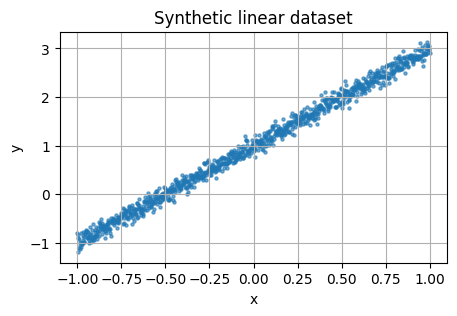

In [2]:
# %%
# Простые данные: y = 2*x + 1 + шум
N = 1000
x = torch.linspace(-1, 1, N).unsqueeze(1)  # [1000, 1]
y = 2 * x + 1 + 0.1 * torch.randn_like(x)

plt.figure(figsize=(5, 3))
plt.scatter(x.numpy(), y.numpy(), s=5, alpha=0.6)
plt.title("Synthetic linear dataset")
plt.xlabel("x"); plt.ylabel("y")
plt.grid(True)
plt.show()

2. Определим "глубокую" сеть (10 скрытых слоёв)

In [3]:
# %%
def make_model(activation_fn):
    layers = []
    in_dim = 1
    hidden_dim = 32
    
    # 10 скрытых слоёв + выход
    for i in range(10):
        layers.append(nn.Linear(in_dim if i == 0 else hidden_dim, hidden_dim))
        layers.append(activation_fn())
    layers.append(nn.Linear(hidden_dim, 1))
    
    return nn.Sequential(*layers)

# Функции активации для сравнения:
sig_model = make_model(nn.Sigmoid)
relu_model = make_model(nn.ReLU)

print("Sigmoid model:")
print(sig_model)
print("\nReLU model:")
print(relu_model)

Sigmoid model:
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=32, out_features=32, bias=True)
  (9): Sigmoid()
  (10): Linear(in_features=32, out_features=32, bias=True)
  (11): Sigmoid()
  (12): Linear(in_features=32, out_features=32, bias=True)
  (13): Sigmoid()
  (14): Linear(in_features=32, out_features=32, bias=True)
  (15): Sigmoid()
  (16): Linear(in_features=32, out_features=32, bias=True)
  (17): Sigmoid()
  (18): Linear(in_features=32, out_features=32, bias=True)
  (19): Sigmoid()
  (20): Linear(in_features=32, out_features=1, bias=True)
)

ReLU model:
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)


3. Обучение + логирование градиентов по слоям

In [4]:
# %%
def train_and_log_grads(model, x, y, lr=0.01, epochs=200):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Храним среднюю абсолютную величину градиентов по слоям
    grad_logs = {name: [] for name, _ in model.named_parameters() if 'weight' in name}
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        
        # Логируем |grad| для каждого weight-параметра
        for name, param in model.named_parameters():
            if 'weight' in name and param.grad is not None:
                grad_logs[name].append(param.grad.abs().mean().item())
        
        optimizer.step()
        
        if epoch % 50 == 0:
            print(f"[Epoch {epoch:3d}] Loss: {loss.item():.4f}")
    
    return grad_logs, loss.item()

4. Запускаем обучение для Sigmoid

In [5]:
# %%
print("=== Training Sigmoid Model ===")
sig_grads, sig_final_loss = train_and_log_grads(sig_model, x, y, lr=0.1, epochs=200)

=== Training Sigmoid Model ===
[Epoch   0] Loss: 3.5280
[Epoch  50] Loss: 1.3374
[Epoch 100] Loss: 1.3374
[Epoch 150] Loss: 1.3374


5. Запускаем обучение для ReLU

In [6]:
# %%
print("\n=== Training ReLU Model ===")
relu_grads, relu_final_loss = train_and_log_grads(relu_model, x, y, lr=0.01, epochs=200)


=== Training ReLU Model ===
[Epoch   0] Loss: 2.5391
[Epoch  50] Loss: 1.3991
[Epoch 100] Loss: 1.3390
[Epoch 150] Loss: 1.3376


6. Визуализация: как менялись градиенты по эпохам

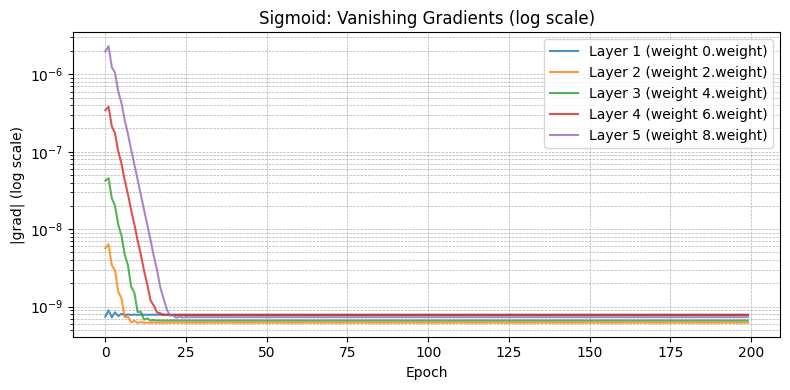

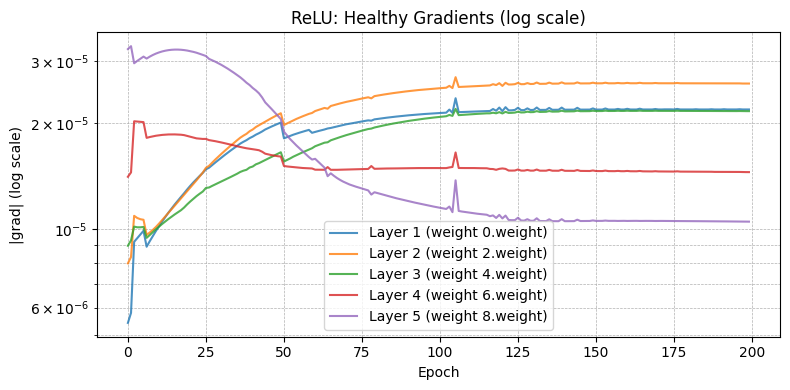

In [7]:
# %%
def plot_grads(grad_logs, title):
    plt.figure(figsize=(8, 4))
    
    # Градиенты весов: возьмём только первые 5 layer-weights (по одному на линейный слой)
    layer_names = [name for name in grad_logs.keys() if 'weight' in name][:5]  # напр.: '0.weight', '2.weight', ...
    
    for i, name in enumerate(layer_names):
        grads = grad_logs[name]
        depth = i + 1  # 1 — первый скрытый слой, 5 — пятый и т.д.
        plt.plot(grads, label=f'Layer {depth} (weight {name})', alpha=0.8)
    
    plt.yscale('log')  # ЛОГАРИФМИЧЕСКАЯ шкала — критично для видимости затухания!
    plt.xlabel('Epoch'); plt.ylabel('|grad| (log scale)')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", lw=0.5)
    plt.tight_layout()
    plt.show()

plot_grads(sig_grads, "Sigmoid: Vanishing Gradients (log scale)")
plot_grads(relu_grads, "ReLU: Healthy Gradients (log scale)")

7. Дополнительно: сравнение loss-кривых

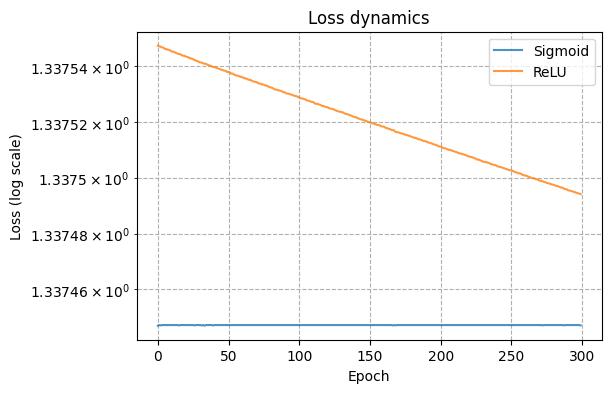

Final loss — Sigmoid: 1.33745, ReLU: 1.33749


In [11]:
# %%
import copy

def train_and_log_loss(model, x, y, lr, epochs=200):
    model_copy = copy.deepcopy(model)
    
    optimizer = optim.SGD(model_copy.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    
    for _ in range(epochs):
        optimizer.zero_grad()
        loss = criterion(model_copy(x), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses

sig_losses = train_and_log_loss(sig_model, x, y, lr=0.1, epochs=300)
relu_losses = train_and_log_loss(relu_model, x, y, lr=0.01, epochs=300)

plt.figure(figsize=(6,4))
plt.plot(sig_losses, label="Sigmoid", alpha=0.8)
plt.plot(relu_losses, label="ReLU", alpha=0.8)
plt.yscale('log')
plt.xlabel("Epoch"); plt.ylabel("Loss (log scale)")
plt.title("Loss dynamics")
plt.legend(); plt.grid(True, which="both", ls="--")
plt.show()

print(f"Final loss — Sigmoid: {sig_losses[-1]:.5f}, ReLU: {relu_losses[-1]:.5f}")